In [1]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import pickle
import zipfile

In [2]:
# Enable the widgets extension for JupyterLab
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
C:\Users\bar24\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:56: UserWarning: See the log file for details: C:\Users\bar24\AppData\Local\Temp\jupyterlab-debug-9kukbepw.log
  warnings.warn(f"See the 

In [3]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [4]:
# Check if CUDA is available
import torch
print(torch.__version__)  
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1+cu121
12.1
90100
True


### Download dataset from Kaggle

In [5]:
# import os
# import shutil
# !pip install kaggle

# # Check if the file already exists in the destination
# if not os.path.exists('/root/.kaggle/kaggle.json'):
#     #kaggle json to /.kaggle
#     os.makedirs('/root/.kaggle', exist_ok=True)
#     shutil.move('kaggle.json', '/root/.kaggle')
#     #permissions
#     os.chmod('/root/.kaggle/kaggle.json', 600)
# else:
#     print("kaggle.json already exists in the destination.")

# # Download the dataset
# !kaggle datasets download -d ashery/chexpert

In [6]:
# import zipfile
# #unzip
# with zipfile.ZipFile('chexpert.zip', 'r') as zip_ref:
#     zip_ref.extractall('./chexpert_data')
# #list files in the extracted dir
# os.listdir("./chexpert_data")

In [7]:
# Global variables

# Define the class names for the medical conditions
class_names = ['Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

# Path to the zip file
zip_path = 'chexpert.zip'


# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read CSV files from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('train.csv') as train_file:
        original_train_df = pd.read_csv(train_file)
    with zip_ref.open('valid.csv') as valid_file:
        test_df = pd.read_csv(valid_file)

# Split the original training data into separate training 
# and validation sets while preserving the original 
# validation test set as the final test set.
train_df, validation_df = split_train_val(original_train_df, policies[-1], class_names)

#### Constructing training dataset

In [8]:
# Import the train dataset
# original_train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')

# # Prepare the dataset using the last policy in the list and the defined class names
# image_paths, label_matrix = prepare_dataset(original_train_df, policies[-1], class_names)

# # Create a DataFrame for the image paths
# image_paths_df = pd.DataFrame({'path': image_paths})

# # Create a DataFrame for the labels with the class names as columns
# labels_df = pd.DataFrame(label_matrix, columns=class_names)

# # Combine the image paths DataFrame and the labels DataFrame
# original_train_df = pd.concat([image_paths_df, labels_df], axis=1)

In [9]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(train_df.head())
print(f"The original training dataset contains {original_train_df.shape[0]} samples.")
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient43609/study1/...,0
1,CheXpert-v1.0-small/train/patient09753/study3/...,0
2,CheXpert-v1.0-small/train/patient24226/study1/...,1
3,CheXpert-v1.0-small/train/patient01545/study19...,1
4,CheXpert-v1.0-small/train/patient34656/study4/...,1


The original training dataset contains 223414 samples.
Number of rows and columns in the train DataFrame: (152821, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object


In [10]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(validation_df.head())
print(f"The original training dataset contains {original_train_df.shape[0]} samples.")
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient30642/study3/...,0
1,CheXpert-v1.0-small/train/patient47165/study1/...,0
2,CheXpert-v1.0-small/train/patient48106/study4/...,0
3,CheXpert-v1.0-small/train/patient35473/study1/...,0
4,CheXpert-v1.0-small/train/patient40872/study1/...,1


The original training dataset contains 223414 samples.
Number of rows and columns in the validation DataFrame: (38206, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object


#### Constructing validation dataset

In [11]:
# Import the validation dataset as final test set
# test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)

In [12]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64735/study1/...,0
1,CheXpert-v1.0-small/valid/patient64634/study1/...,0
2,CheXpert-v1.0-small/valid/patient64712/study1/...,0
3,CheXpert-v1.0-small/valid/patient64662/study1/...,0
4,CheXpert-v1.0-small/valid/patient64578/study1/...,0


Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object


In [13]:
# import monai
# from monai.transforms import (
#     Compose, LoadImageD, ScaleIntensityD, ToTensorD, RandRotateD, RandFlipD, AsDiscrete, Activations
# )
# from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
# from monai.networks.nets import DenseNet121
# from monai.losses import DiceLoss
# from monai.metrics import DiceMetric
# import torch
# import numpy as np
# import pandas as pd
# import zipfile
# from sklearn.model_selection import train_test_split
# from torchvision import transforms
# from PIL import Image
# from dataset import CheXpertDataset

# # Check if CUDA is available and set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")


# # Define the transformation pipeline using torchvision
# torchvision_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
#     transforms.ToTensor(),          # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
# ])

# # Create the training dataset with the defined transformations
# train_dataset = CheXpertDataset(train_df, class_names, zip_path, transform=torchvision_transforms)

# # Create the validation dataset with the defined transformations
# valid_dataset = CheXpertDataset(validation_df, class_names, zip_path, transform=torchvision_transforms)

# # Create DataLoader for the training dataset
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# # Create DataLoader for the validation dataset
# valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# # Define the model
# model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=1).to(device)

# # Define the loss function
# criterion = DiceLoss(sigmoid=True)

# # Define the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Define post-processing transforms
# post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# # Define the Dice metric
# dice_metric = DiceMetric(include_background=True, reduction="mean")

# # Training loop
# num_epochs = 20
# val_interval = 1
# best_metric = -1
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []

# for epoch in range(num_epochs):
#     print("-" * 10)
#     print(f"epoch {epoch + 1}/{num_epochs}")
#     model.train()
#     epoch_loss = 0
#     step = 0
#     for batch_data in train_loader:
#         step += 1
#         inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")
#     epoch_loss /= step
#     epoch_loss_values.append(epoch_loss)
#     print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         with torch.no_grad():
#             val_images = None
#             val_labels = None
#             val_outputs = None
#             for val_data in valid_loader:
#                 val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
#                 val_outputs = model(val_images)
#                 val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_trans(i) for i in decollate_batch(val_labels)]
#                 dice_metric(y_pred=val_outputs, y=val_labels)
#             metric = dice_metric.aggregate().item()
#             dice_metric.reset()
#             metric_values.append(metric)
#             if metric > best_metric:
#                 best_metric = metric
#                 best_metric_epoch = epoch + 1
#                 torch.save(model.state_dict(), "best_metric_model.pth")
#                 print("saved new best metric model")
#             print(
#                 f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
#                 f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
#             )

# print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

#### Dataset formation according to torch (using dataloaders)

In [14]:
# Define the transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Define the class names for the medical conditions
class_names = ['Pleural Effusion']

# Create the training dataset with the defined transformations 
train_dataset = CheXpertDataset(dataframe=train_df, class_names=class_names, zip_path=zip_path, transform=transform)

# Create the validation dataset with the defined transformations
valid_dataset = CheXpertDataset(dataframe=validation_df, class_names=class_names, zip_path=zip_path, transform=transform)

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for the validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Verify data loading by fetching a batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

# Fetch a batch of images and labels from the validation DataLoader
# test_X contains the images and test_Y contains the
# corresponding labels from the validation set
test_X, test_Y = next(iter(valid_loader))

#### Visualising example

Original shape: torch.Size([3, 224, 224]), New shape: (224, 224, 3)
Example image:


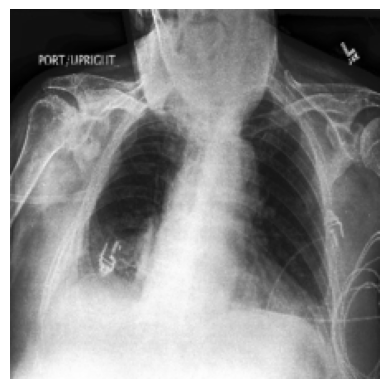

In [15]:
# Select the first image in the batch
image = test_X[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224, 3)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 3), f"Expected shape (224, 224, 3), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models (in the given example, Resnet18.).

In [16]:
# Load a pre-trained DenseNet169 model, add custom layers, and freeze certain layers
# 
# Parameters:
# - pretrained: Use a pre-trained version of DenseNet169
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
denseNet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
model = upload_pretrained(denseNet169, add_layers=True, n_labels=len(class_names), freeze_layers=True)

# Move the model to the appropriate device
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

#### Summary of Model

In [17]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (45,440)
|    |    └─_DenseLayer: 3-2             (49,600)
|    |    └─_DenseLayer: 3-3             (53,760)
|    |    └─_DenseLayer: 3-4             (57,920)
|    |    └─_DenseLayer: 3-5             (62,080)
|    |    └─_DenseLayer: 3-6             (66,240)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (512)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (32,768)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (53,760)
|    |    └─_DenseLayer: 3-12            (57,920)
|    |

#### Here is how we train the model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with weight decay
# Adam optimizer with learning rate of 0.001 and weight decay
optimizer_densenet = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer_densenet, mode='min', factor=0.1, patience=5, verbose=True)

# Define the number of epochs
num_epochs = 20

# Train the model
# Parameters:
# - model: The model to be trained (DenseNet169 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses, train_accuracies, test_losses, test_accuracies, test_aucs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer_densenet,
    num_epochs=num_epochs,
    device=device,
    save_filename='model.pth'
)

# Adjust the learning rate based on the validation loss
for epoch in range(num_epochs):
    # Training and evaluation code here...
    scheduler.step(test_losses[-1])  # Adjust the learning rate based on the latest validation loss

c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20:   0%|          | 0/9552 [00:00<?, ?batch/s]

### Pickle the trained model

In [ ]:
# Save the trained model using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as model.pkl")

In [ ]:
# Define dummy input for ONNX export (batch size 1, 3 channels, 224x224 image size)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Move dummy input to GPU

# Export the model to ONNX format
onnx_filename = "model.onnx"
torch.onnx.export(model, dummy_input, onnx_filename,
                  input_names=["input"], output_names=["output"],
                  opset_version=11)

print(f"Model saved as {onnx_filename}")

### Load the trained model

In [ ]:
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print("Model loaded from model.pkl")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Create the test dataset with the defined transformations
test_dataset = CheXpertDataset(test_df, class_names, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test dataset
test_preds, test_labels = evaluate_model(loaded_model, test_loader, device)

# Binarize the predictions
test_preds_binary = (test_preds > 0.5).astype(int)

# Check which classes exist in test_df
existing_classes_indices = [i for i in range(len(class_names)) if test_labels[:, i].sum() > 0]
existing_classes = [class_names[i] for i in existing_classes_indices]
print("Existing classes in test_df:", existing_classes)

# Filter the predictions and labels to only include existing classes
test_preds_binary_filtered = test_preds_binary[:, existing_classes_indices]
test_labels_filtered = test_labels[:, existing_classes_indices]

# Debugging information
print("Test Labels (Filtered):")
print(test_labels_filtered)
print("Test Predictions (Filtered):")
print(test_preds_binary_filtered)

# Calculate F1 scores
f1_scores = f1_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
f1_scores_df = pd.DataFrame({'Class': existing_classes, 'F1 Score': f1_scores})

# Calculate precision scores
precision_scores = precision_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
precision_scores_df = pd.DataFrame({'Class': existing_classes, 'Precision': precision_scores})

# Calculate recall scores
recall_scores = recall_score(test_labels_filtered, test_preds_binary_filtered, average=None, zero_division=0)
recall_scores_df = pd.DataFrame({'Class': existing_classes, 'Recall': recall_scores})

# Calculate accuracy
accuracy = accuracy_score(test_labels_filtered, test_preds_binary_filtered)

# Calculate confusion matrix for each class
conf_matrices = []
for i, class_name in enumerate(existing_classes):
    conf_matrix = confusion_matrix(test_labels_filtered[:, i], test_preds_binary_filtered[:, i])
    conf_matrices.append(conf_matrix)
    print(f"Confusion Matrix for {class_name}:\n{conf_matrix}")

# Classification report
class_report = classification_report(test_labels_filtered, test_preds_binary_filtered, target_names=existing_classes, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report).transpose()

# Save F1 scores to CSV
f1_scores_df.to_csv('f1_scores.csv', index=False)

# Save precision scores to CSV
precision_scores_df.to_csv('precision_scores.csv', index=False)

# Save recall scores to CSV
recall_scores_df.to_csv('recall_scores.csv', index=False)

# Save classification report to CSV
class_report_df.to_csv('classification_report.csv')

# Plot confusion matrix for each class
for i, class_name in enumerate(existing_classes):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Print additional evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Scores:\n{f1_scores_df}")
print(f"Precision Scores:\n{precision_scores_df}")
print(f"Recall Scores:\n{recall_scores_df}")